# Implementing Grover's Algorithm with Qiskit

Grover's algorithm is a quantum search algorithm that efficiently finds a target item in an unsorted database. It works by amplifying the probability of the correct answer through a series of quantum operations.

In this example, we will use Grover's algorithm to search for a specific binary string in a database, demonstrating a technique that can be applied to various search problems, including solving optimization tasks and finding specific solutions in large datasets.

In [1]:
import os
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

# Retrieve the API token from the environment variable
api_token = os.environ.get("IBM_RPI_TOKEN")

# Initialize the QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', token=api_token)

# Set the backend to ibm_rensselaer
backend = service.least_busy(["ibm_rensselaer"])

In [42]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit.circuit.library import MCXGate

# Function to create the Grover Oracle
def create_oracle(target):
    oracle = QuantumCircuit(len(target))
    for qubit, bit in enumerate(target):
        if bit == '0':
            oracle.x(qubit)
    oracle.h(len(target) - 1)
    oracle.append(MCXGate(num_ctrl_qubits=len(target)-1), list(range(len(target))))
    oracle.h(len(target) - 1)
    for qubit, bit in enumerate(target):
        if bit == '0':
            oracle.x(qubit)
    return oracle

# Number of qubits needed
n_qubits = 3  # For your dataset with binary strings of length 3
grover_circuit = QuantumCircuit(n_qubits)

# Apply Hadamard gates to all qubits to create superposition
grover_circuit.h(range(n_qubits))

# Add the Oracle
oracle = create_oracle('101')  # Targeting the '101' state
grover_circuit.compose(oracle, inplace=True)

# Apply the Grover diffusion operator manually
grover_circuit.h(range(n_qubits))
grover_circuit.x(range(n_qubits))
grover_circuit.h(n_qubits - 1)
grover_circuit.append(MCXGate(num_ctrl_qubits=n_qubits-1), list(range(n_qubits)))
grover_circuit.h(n_qubits - 1)
grover_circuit.x(range(n_qubits))
grover_circuit.h(range(n_qubits))

# Add measurement
grover_circuit.measure_all()

In [45]:
# Transpile the circuit with optimization for the backend
transpiled_circuit = transpile(
    grover_circuit,
    backend=backend,
    optimization_level=3,  # High level of optimization
)

from qiskit.transpiler.passes.scheduling import ALAPSchedule
from qiskit.transpiler import InstructionDurations, PassManager

# Define the instruction durations based on the backend
durations = InstructionDurations.from_backend(backend)

# Schedule the circuit using ALAP (As Late As Possible)
schedule_pass = ALAPSchedule(durations)
scheduled_circuit = PassManager(schedule_pass).run(transpiled_circuit)

In [47]:
# (Removed Dynamical Decoupling as it was causing errors)
transpiled_circuit_dd = scheduled_circuit


TranspilerError: 'Duration of y on qubits [0] is not found.'

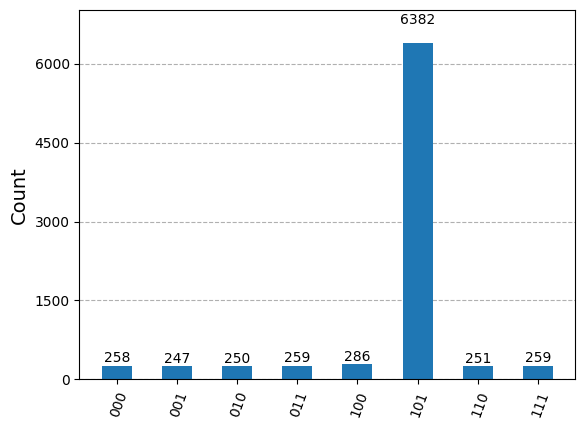

In [35]:
# Step 1: Run on a simulator with many shots
simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(grover_circuit, simulator)
job = simulator.run(transpiled_circuit, shots=8192)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)


In [37]:
# Step 4: Run on a real quantum backend with error mitigation
with Session(backend=backend) as session:
    sampler = Sampler()
    job = sampler.run(pubs=[grover_circuit], shots=8192)
    result = job.result()

# Access the first PubResult and visualize results
pub_result = result._pub_results[0]
bit_array = pub_result.data.meas
counts = bit_array.get_counts()
plot_histogram(counts)


IBMInputValueError: 'The instruction h on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/guides/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/guides/primitives-examples) to see this coupled with operator transformations.'